### Prueba implementación Saliency y Activation Maps

Visualizamos cómo variaciones en los parámetros del modelo físico
impactan en las unidades del espacio latente.

La idea es calcular derivadas en las unidades del espacio latente, respecto de los parámetros del modelo físico, utilizando la regla de la cadena:
$$\frac{d \ Unit}{d \alpha} = \frac{d \ Unit}{d I}\frac{d I}{d \alpha},$$
donde $\alpha$ es un parámetro del modelo físico, en este caso SSA, e $I$ es la imagen generada a la salida de dicho modelo, en este caso un tensor de $30\times30\times3$ con cada uno de los canales de la matriz de scattering $\sigma_{pq}\left(\theta, \phi\right)$.

Comenzamos implementando saliency maps, para entender cómo las variaciones a nivel imágenes. Equivalente a calcular la primera derivada de la regla de la cadena: $\frac{d \ Unit}{d I}$. 

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

class ConvAutoencoder(Model):
    
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (45,90,1)), 
                                            layers.Conv2D(4, (7, 7), strides=1, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(8, (5, 5), strides=1, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(8, (3, 3), strides=2, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Flatten(),
                                            
                                            layers.Dense(units=17*39*8, activation='relu'),
                                            layers.Dense(units=256, activation='relu'),
                                            layers.Dense(units=64, activation='relu'),

                                            layers.Dense(latent_dim, activation = 'linear')])
      
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),

                                            layers.Dense(units=64, activation='relu'),
                                            layers.Dense(units=256, activation='relu'),
                                            layers.Dense(units=17*39*8, activation='relu'),
                                            
                                            layers.Reshape(target_shape=(17,39,8)),
                                            
                                            layers.Conv2DTranspose(8, (3, 4), strides=2, activation="relu"),
                                            
                                            layers.Conv2DTranspose(8, (5, 5), strides=1, activation="relu"),

                                            layers.Conv2DTranspose(4, (7, 7), strides=1, activation='relu'),

                                            layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
  
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

In [32]:
import os
latent_dim = 3

# Get weights path
rel_path = os.path.join(os.getcwd(), "../../results")
file_name = f"weights_lat_{latent_dim}_ssa_two_layer_HH.h5"
weights_path = os.path.join(rel_path, file_name)

# Load model with weights
model = ConvAutoencoder(latent_dim)
model.build(input_shape=(16000, 45, 90, 1))
model.load_weights(weights_path)

Con el modelo entrenado, pasamos imágenes por el encoder y observamos la salida.

(-1.0, 1.0)

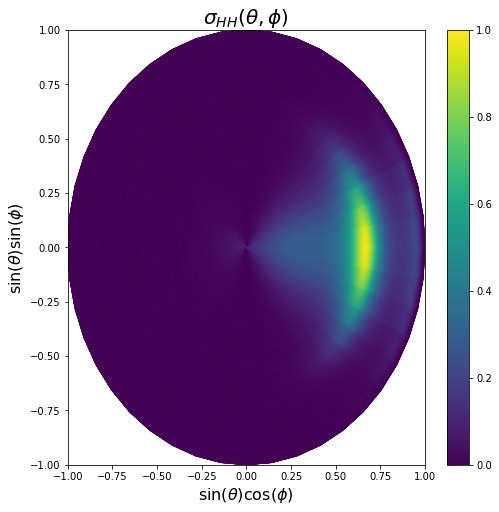

In [46]:
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl

# Prepare some input images
folder = os.getcwd().split('/')[:-2]
file_name = "results/SSA_tl_test_set.npy"

file_path = os.path.join("/".join(folder), file_name)
sigma_test = np.load(file_path)

# Visualize random test element
rng = np.random.default_rng()
idx = rng.integers(sigma_test.shape[0])
img = sigma_test[idx, :, :, 0]

# Parámetros para recorrer
theta, phi = np.linspace(1e-5, 89, 90)*np.pi / \
    180, np.linspace(0, 360, 45)*np.pi/180
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

fig = plt.figure(figsize=(8, 8))

# Canal HH
ax = plt.subplot(1, 1, 1)
c = ax.pcolormesh(kx, ky, img,
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

Definimos la función score que me selecciona qué unidad del espacio latente mirar, y el objeto Saliency, para calcular attention o saliency maps respecto de cada unidad.

In [47]:
# Create score object to select outputs
#from tf_keras_vis.utils.scores import CategoricalScore
from functools import partial    

def score_function(output, l_dim):
    return output[:, l_dim]

In [48]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# Create Saliency object.
saliency = Saliency(model.encoder)
img = np.expand_dims(img, axis=-1)

# Generate saliency map
saliency_map = np.array([saliency(partial(score_function, l_dim=l), seed_input=img)[0,:,:] 
                        for l in range(latent_dim)])
saliency_map.shape

(3, 45, 90)

Visualizamos saliency_map

(-1.0, 1.0)

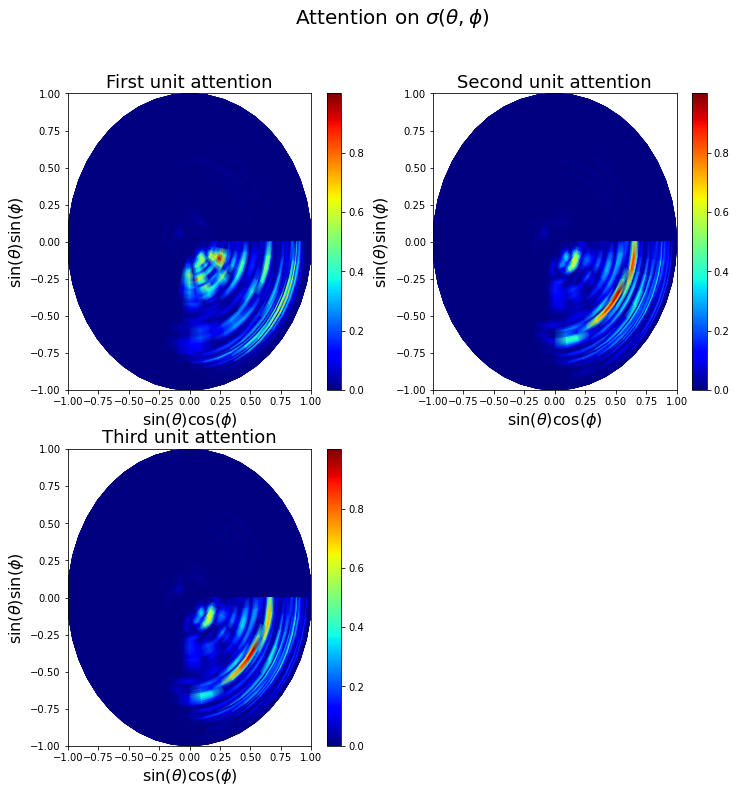

In [49]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle(r'Attention on $\sigma(\theta,\phi)$', fontsize = 20)

# First Unit
ax = plt.subplot(2, 2, 1)
c = ax.pcolormesh(kx, ky, saliency_map[0], cmap='jet',shading = 'gouraud')
plt.title(r'First unit attention', fontsize = 18)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Second Unit
ax = plt.subplot(2, 2, 2)
c = ax.pcolormesh(kx, ky, saliency_map[1], cmap='jet',shading = 'gouraud')
plt.title(r'Second unit attention', fontsize = 18)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Third Unit
ax = plt.subplot(2, 2, 3)
c = ax.pcolormesh(kx, ky, saliency_map[2], cmap='jet',shading = 'gouraud')
plt.title(r'Third unit attention', fontsize = 18)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))   


#### Calculamos derivadas respecto de los parámetros del modelo

Primero generamos imágenes barriendo los posibles valores de la constante dieléctrica de la primer superficie -$ \epsilon_{1} $-, fijando el resto de los parámetros del modelo en su valor mínimo.

In [37]:
from itertools import product

import sys
sys.path.append("../small_perturbation_method")
import spm1

from two_rough_layers import *

# Genero datos barriendo epsilon
k0 = 2*pi/.25
d = 2*pi*3.1/k0
epsilon1, epsilon2 = np.arange(3, 53), np.arange(3, 53)
s1, s2 = .01, .01
l1, l2 = 10*s1, 10*s2
theta_i, phi_i = 45*np.pi/180, 0*np.pi/180
acf = 1

# Inicializo algunas variables
sigma = np.zeros((len(epsilon1), len(epsilon2), PHI.shape[0], PHI.shape[1]))
d_img = np.zeros((len(epsilon1), len(epsilon2), latent_dim, PHI.shape[0], PHI.shape[1]))

# Defino un generador para tener indices del producto cartesiano
def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

# Armo una tupla con los argumentos de S01
for idx, eps in enumerated_product(epsilon1, epsilon2):
    #   # Calculo el vector de onda incidente parallelo 
    # kx_i = spm1.kix(k0, theta_i, phi_i)
    # ky_i = spm1.kiy(k0, theta_i, phi_i)
    # k1 = kx - kx_i
    # k2 = ky - ky_i

    # # Armo una tupla con los argumentos de S01     
    # args = (k0, theta_i, phi_i,
    #         THETA, PHI, 
    #         9, ep2,
    #         d, s2, l1,
    #         s, l2,
    #         k1, k2, acf)

    # # Calculo la sección eficaz y agrego ruido
    # # h-pol
    # s_hh = spm1.S01HH(*args)
    ep1, ep2 = eps
    idx1, idx2 = idx

    args = (k0, THETA, PHI,
            theta_i, phi_i,
            ep1, ep2,
            s1, l1,
            s2, l2,
            d)

    # Calculo la sección eficaz y agrego ruido
    s_O1 = suma_O1(*args)

    #h-pol
    s_hh = s_O1[1, 1]
    s_hh_noise = s_hh + rng.normal(0, .03*np.mean(s_hh), size=PHI.shape)

    # Guardo los resultados en un tensor: primero apilo los tres canales (stack)
    # Cuenta cantidad de NaNs
    cond = np.count_nonzero(np.isnan(s_hh_noise))

    if not cond:
        img = s_hh_noise/np.max(np.abs(s_hh_noise))
        sigma[idx1, idx2, :, :] = img
        d_img[idx1, idx2, :, :, :] = np.array([saliency(partial(score_function, l_dim=l), seed_input=img[:,:,None])[0,:,:] 
                        for l in range(latent_dim)])
    else:
        raise ValueError(f'Input contains NaN, infinity or a value too large for {s_hh_noise.dtype}')



Guardo las salidas del modelo para analizar también.

In [38]:
# Expando para que las imagnes coincidan con la entrada del modelo
expanded_sigma = np.expand_dims(sigma, axis=-1)
size = expanded_sigma.shape

# Guardo la salida del encoder
latent_space = model.encoder(expanded_sigma.reshape((-1, size[2], size[3], size[4]))).numpy()
latent_space.resize(size[0], size[1], latent_dim)

In [39]:
print(f'Tamaño de las imagenes biestáticas: {sigma.shape}')
print(f'Tamaño del los Saliency maps: {d_img.shape}')
print(f'Tamaño de las imagenes codificadas: {latent_space.shape}')

Tamaño de las imagenes biestáticas: (50, 50, 45, 90)
Tamaño del los Saliency maps: (50, 50, 3, 45, 90)
Tamaño de las imagenes codificadas: (50, 50, 3)


Calculamos la derivada de la matriz de scattering respecto del parámetro que acabamos de variar $\frac{d I}{d\alpha}=\frac{d\sigma}{d\epsilon_{1}}$, y multiplicamos por los Saliency Maps.

In [40]:
# Spacing between differential arg
d_alpha = 1#.0003

# Derivada respecto de alpha
d_sigma = np.gradient(sigma, d_alpha, axis=(0, 1))

# Hacemos un reshape para poder contraer indices más fácil
print(d_sigma[0].shape)

#Variacion de cada unidad respecto a epsilon
d_Unit = np.einsum('ijklm, ijlm -> ijk', d_img, d_sigma[0])
print(d_Unit.shape)


(50, 50, 45, 90)
(50, 50, 3)


Text(0.5, 0.92, 'Third Unit Variation wrt $\\epsilon_{1}$')

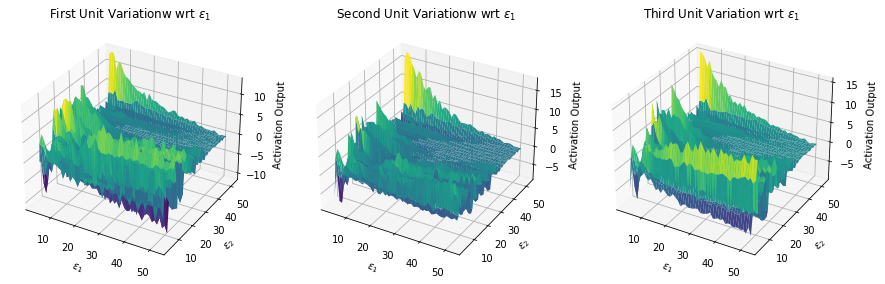

In [41]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 48),
        subplot_kw={"projection": "3d"})

EP1, EP2 = np.meshgrid(epsilon1, epsilon2)

# Primera Unidad
ax[0].plot_surface(EP1, EP2, d_Unit[:, :, 0], cmap='viridis')
ax[0].set_xlabel('$\epsilon_{1}$')
ax[0].set_ylabel('$\epsilon_{2}$')
ax[0].set_zlabel('Activation Output')
ax[0].set_title('First Unit Variationw wrt $\epsilon_{1}$')

# Second Unidad
ax[1].plot_surface(EP1, EP2, d_Unit[:, :, 1], cmap='viridis')
ax[1].set_xlabel('$\epsilon_{1}$')
ax[1].set_ylabel('$\epsilon_{2}$')
ax[1].set_zlabel('Activation Output')
ax[1].set_title('Second Unit Variationw wrt $\epsilon_{1}$')

# Tercera Unidad
ax[2].plot_surface(EP1, EP2, d_Unit[:, :, 2], cmap='viridis')
ax[2].set_xlabel('$\epsilon_{1}$')
ax[2].set_ylabel('$\epsilon_{2}$')
ax[2].set_zlabel('Activation Output')
ax[2].set_title('Third Unit Variation wrt $\epsilon_{1}$')


Text(0.5, 0.92, 'Third Unit Activation')

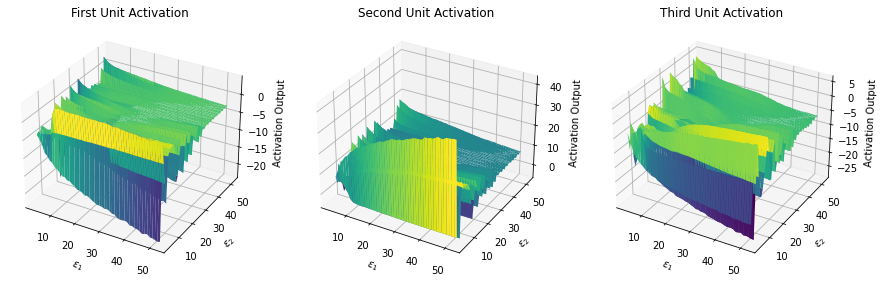

In [52]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 48),
        subplot_kw={"projection": "3d"})

EP1, EP2 = np.meshgrid(epsilon1, epsilon2)

# Primera Unidad
ax[0].plot_surface(EP1, EP2, latent_space[:, :, 0], cmap='viridis')
ax[0].set_xlabel('$\epsilon_{1}$')
ax[0].set_ylabel('$\epsilon_{2}$')
ax[0].set_zlabel('Activation Output')
ax[0].set_title('First Unit Activation')

# Second Unidad
ax[1].plot_surface(EP1, EP2, latent_space[:, :, 1], cmap='viridis')
ax[1].set_xlabel('$\epsilon_{1}$')
ax[1].set_ylabel('$\epsilon_{2}$')
ax[1].set_zlabel('Activation Output')
ax[1].set_title('Second Unit Activation')

# Tercera Unidad
ax[2].plot_surface(EP1, EP2, latent_space[:, :, 2], cmap='viridis')
ax[2].set_xlabel('$\epsilon_{1}$')
ax[2].set_ylabel('$\epsilon_{2}$')
ax[2].set_zlabel('Activation Output')
ax[2].set_title('Third Unit Activation')

Text(0.5, 1.0, 'First Unit Activation')

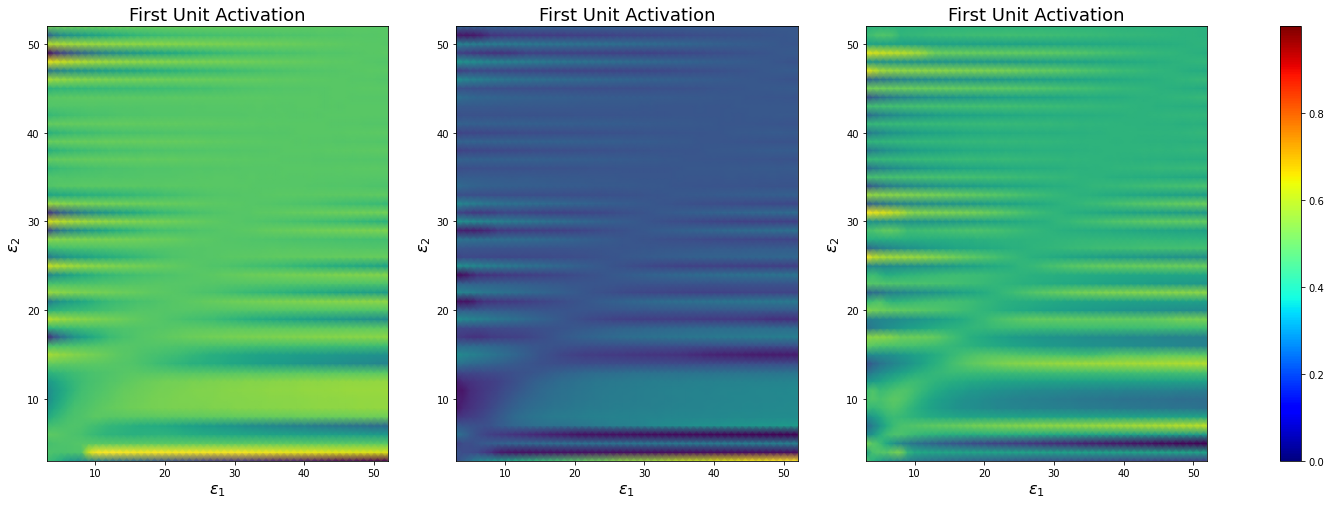

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(26, 8))

EP1, EP2 = np.meshgrid(epsilon1, epsilon2)

# Primera Unidad
ax[0].pcolormesh(EP1, EP2, latent_space[:, :, 0], 
                    shading='gouraud', cmap='viridis')
ax[0].set_xlabel('$\epsilon_{1}$', fontsize=16)
ax[0].set_ylabel('$\epsilon_{2}$', fontsize=16)
ax[1].set_ylabel('$\epsilon_{2}$', fontsize=16)
ax[1].set_title('First Unit Activation', fontsize=18)


# Primera Unidad
ax[2].pcolormesh(EP1, EP2, latent_space[:, :, 2], 
                    shading='gouraud', cmap='viridis')
ax[2].set_xlabel('$\epsilon_{1}$', fontsize=16)
ax[2].set_ylabel('$\epsilon_{2}$', fontsize=16)
ax[2].set_title('First Unit Activation', fontsize=18)
